In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Cloning into 'dl_basics'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 52 (delta 12), reused 38 (delta 8), pack-reused 0
Unpacking objects: 100% (52/52), 578.94 KiB | 7.72 MiB/s, done.
Found GPU: Tesla T4.


In [2]:
from data_gen.synth_sequences import SynthMathData
import models
import utils

In [59]:
P = {}

P["SynthMathData"] = {
    "batch_size" : 32,
    "seq_len" : 32,
    "operation" : "add",
    "distribution" : "normal",
    "seed" : 42,
}

data_gen = SynthMathData(**P["SynthMathData"])
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)

(32, 32, 2) float32 (32,) float32


In [60]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 32,
    "num_outputs" : 1,
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "num_hidden_gru" : 3,
    "use_embedding" : False,
    "return_final_hidden" : True,
}
'''

P["model_name"] = "mlp_2d_01"
P["model_build_params"] = {
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "layer_units" : [128,128,1],
    "activation" : "relu",
}


model = eval("models." + P["model_name"])(**P["model_build_params"])

model.compile(
    loss = "mse",
    optimizer = "adam",
    metrics = [ "mae" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

Model: "mlp_2d_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 2)]           0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 32, 2, 1)         0         
 a)                                                              
                                                                 
 dense_0 (Conv2D)            (None, 1, 1, 128)         8320      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 tf.nn.relu_2 (TFOpLambda)   (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                         

In [63]:
NUM_EPOCHS = 1024*6
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    data_gen,
    epochs = NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

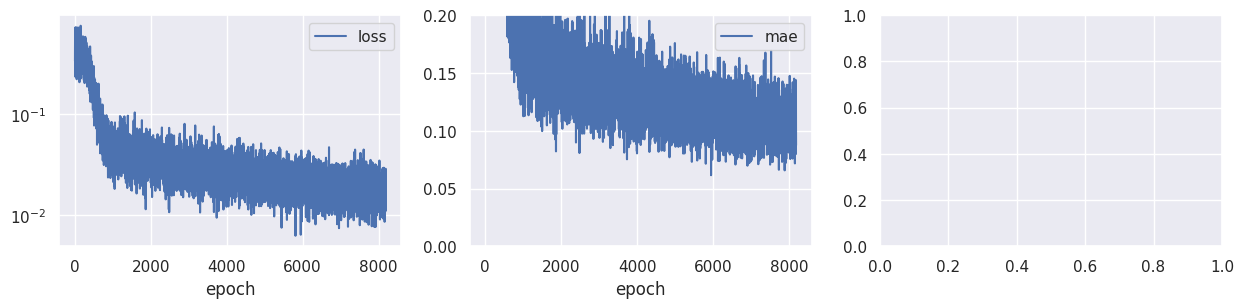

In [64]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

sns.lineplot(data=run.history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["mae"]], ax=axs[1], dashes=False);
axs[1].set_ylim(0,0.2);

#sns.lineplot(data=run.history[["lr"]], ax=axs[2], dashes=False);

In [13]:
model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics = [ "mae" ]
)

In [ ]:
run.save_state(os.path.join(OUTPUT_DIR, P["run_dir"]), P, model)

In [ ]:
P, model = run.load_state("../output/gru_01-230407-220913")

In [54]:
y_pred = model.predict(x)

1/1 [==============================] - 1s 1s/step


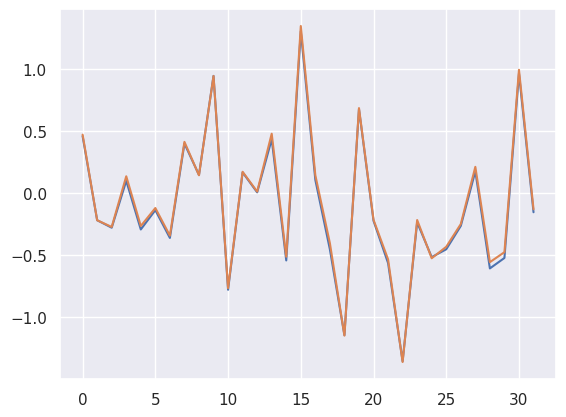

In [55]:
plt.plot(y_pred)
plt.plot(y)